In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import qutip
import numpy as np
import qutip
import scqubits
from scipy.optimize import minimize
from IPython.display import clear_output
from functools import partial
import pickle
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from CoupledQuantumSystems.evo import ODEsolve_and_post_process
from CoupledQuantumSystems.noise import *
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.IFQ import gfIFQ

In [2]:
EJ = 4
EC = EJ/2
EL = EJ/30

qbt = gfIFQ(EJ = EJ,EC =EC,EL = EL,truncated_dim=4)

e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(4)]

# qbt.fluxonium.plot_wavefunction(which=[0,1,2,3,4,5,6,7,8,9,10])

In [3]:
def objective(x,detuning,t_duration):
    amp1_scaling_factor = x[0]
    amp2_scaling_factor = x[1]

    detuning1 = detuning
    detuning2 = detuning
    tlist = np.linspace(0,t_duration,t_duration*2)

    results  = qbt.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(qbt.truncated_dim, 0),qutip.basis(qbt.truncated_dim, 2)],
        tlist = tlist,
        drive_terms = qbt.get_Raman_DRAG_drive_terms(
            i = 0,
            j = 3,
            k = 2,
            detuning1=detuning1,
            detuning2 = detuning2,
            t_duration=t_duration,
            shape='sin^2',
            amp_scaling_factor = 1,
            amp1_scaling_factor = amp1_scaling_factor,
            amp2_scaling_factor = amp2_scaling_factor,
            amp1_correction_scaling_factor = 0,
            amp2_correction_scaling_factor = 0,
        ),
        # c_ops = c_ops,
        e_ops = e_ops
    )
    clear_output()
    print(f"x:{x}, {detuning},{t_duration}")
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()

    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1] + 0.98* results[0].expect[1][-1]))
    one_minus_pop0 = np.abs(1- (results[1].expect[0][-1] +  0.98* results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop0))
    return one_minus_pop2 + one_minus_pop0

In [5]:
with open('results_backup.pkl', 'rb') as f:
    old_results_dict =   pickle.load( f)

x:[2.59701126 2.57905629], 0.5,50


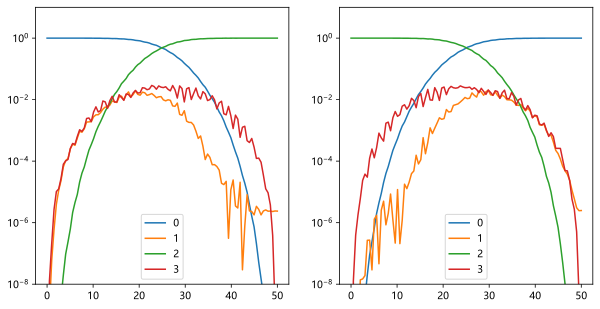

(5.008058168165519e-08, 5.1961967173497214e-08)


In [7]:


results_dict = {}
for detuning, t_duration, amp_guess in [
                                        (0.1,200,2.3),
                                        (0.2,200,3),
                                        (0.3,200,4),
                                        (0.4,200,4.9),
                                        (0.5,200,5),
                                            
                                        (0.1,150,2),
                                        (0.2,150,2.8),
                                        (0.3,150,3.3),
                                        (0.4,150,4.2),
                                        (0.5,150,4.2),
                                        


                                        (0.1,100,1.7),
                                        (0.2,100,2.3),
                                        (0.3,100,2.6),
                                        (0.4,100,3.8),
                                        (0.5,100,3.6),
    
                                        (0.1,50,1),
                                        (0.2,50,1.7),
                                        (0.3,50,2.1),
                                        (0.4,50,3.3),
                                        (0.5,50,2.2),
                                        ]:
        new_obj = partial(objective, detuning=detuning,t_duration=t_duration)
        amp1, amp2  = old_results_dict[(detuning, t_duration)]
        result = minimize(new_obj, [amp1, amp2 ], method='Nelder-Mead')
        results_dict[(detuning, t_duration)] = result.x
        with open('results_backup_four_level.pkl', 'wb') as f:
            pickle.dump(results_dict, f)

In [62]:
with open('results_backup_four_level.pkl', 'rb') as f:
    results_dict =   pickle.load( f)

In [8]:

qbt = gfIFQ(EJ = EJ,EC =EC,EL = EL,truncated_dim=13)

e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(10)]

In [9]:
state_0_dressed = qutip.basis(qbt.truncated_dim, 0)
state_1_dressed = qutip.basis(qbt.truncated_dim, 2)
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

temp_in_mK = 20
Q_cap = 1e5
one_over_f_flux_noise_amplitude = 1e-6

c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        Q_cap,
                        one_over_f_flux_noise_amplitude) + qbt.get_Tphi_c_ops(one_over_f_flux_noise_amplitude)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(12)]


def truncate_to_computational(state,i,j):
    if state.isket:
        state = qutip.ket2dm(state)
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]


states_ideal_after_gate = []
for state in states_ideal:
    states_ideal_after_gate.append(qutip.qip.operations.x_gate() * state)
    
def calc_average_fidelity_with_phase(phase,dms,states_ideal_after_gate):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal_after_gate):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)

def get_e_pop(state):
    return qutip.expect(qutip.ket2dm(qutip.basis(qbt.truncated_dim,1)), state)
def get_e_pop_j(state, j):
    return qutip.expect(qutip.ket2dm(qutip.basis(qbt.truncated_dim,j)), state)

def get_leakage_trace(state,i,j):
    if state.isket:
        state = qutip.ket2dm(state)
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    return 1-dm.tr()

 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/CoupledQuantumSystems/IFQ.py: 63

In [10]:
detuning_arr = np.array([0.1,0.2,0.3,0.4,0.5])
t_duration_arr = np.array([50,100,150,200])
fidelity_arr = np.zeros(shape = (len(detuning_arr),len(t_duration_arr)))
leak_to_e_arr = np.zeros(shape = (len(detuning_arr),len(t_duration_arr)))
additional_leakage_arr = np.zeros(shape = (len(detuning_arr),len(t_duration_arr)))

for i,detuning in enumerate(detuning_arr):
    for j, t_duration in enumerate(t_duration_arr):
        amp1, amp2  = results_dict[(detuning, t_duration)]
        tlist = np.linspace(0,t_duration,10*t_duration)

        amp1_scaling_factor = amp1
        amp2_scaling_factor = amp2
        detuning1 = detuning
        detuning2 = detuning

        results  = qbt.run_qutip_mesolve_parrallel(
            initial_states = initial_states,
            tlist = tlist,
            drive_terms = qbt.get_Raman_DRAG_drive_terms(
                i = 0,
                j = 3,
                k = 2,
                detuning1=detuning1,
                detuning2 = detuning2,
                t_duration=t_duration,
                shape='sin^2',
                amp_scaling_factor = 1,
                amp1_scaling_factor = amp1_scaling_factor,
                amp2_scaling_factor = amp2_scaling_factor,
                amp1_correction_scaling_factor = 0,
                amp2_correction_scaling_factor = 0,
            ),
            c_ops = c_ops,
            e_ops = e_ops
        )
        dms = [truncate_to_computational(result.states[-1], 0,2) for result in results]
        def objective_function(phase):
            return calc_average_fidelity_with_phase(phase[0], dms, states_ideal_after_gate)
        opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
        fidelity_arr[i,j] = opt_result.fun

        leakage_to_list = []
        for l in range(len(e_ops)):
            leakage_to_list.append( [get_e_pop_j(result.states[-1], l) for result in results])

        leak_to_e_arr[i,j] = np.mean(leakage_to_list[1])
        additional_leakage_arr[i,j]= 1- np.mean(leakage_to_list[1]) - np.mean(leakage_to_list[0]) - np.mean(leakage_to_list[2])
        

 Total run time:   1.07s*] Elapsed 1.07s / Remaining 00:00:00:00 [*********99%***********] Elapsed 1.07s / Remaining 00:00:00:00[*******  29%           ] Elapsed 0.37s / Remaining 00:00:00:00
 Total run time:   1.21s*] Elapsed 1.21s / Remaining 00:00:00:00 [*********99%***********] Elapsed 1.20s / Remaining 00:00:00:00
 Total run time:   1.21s*] Elapsed 1.21s / Remaining 00:00:00:00
 Total run time:   1.22s*] Elapsed 1.22s / Remaining 00:00:00:00
 Total run time:   1.31s*] Elapsed 1.31s / Remaining 00:00:00:00
 Total run time:   1.51s*] Elapsed 1.51s / Remaining 00:00:00:00
 Total run time:   2.22s ] Elapsed 2.25s / Remaining 00:00:00:00 [*********86%********   ] Elapsed 2.23s / Remaining 00:00:00:00
 Total run time:   2.52s*] Elapsed 2.52s / Remaining 00:00:00:00[*********95%********** ] Elapsed 2.50s / Remaining 00:00:00:000
 Total run time:   2.54s*] Elapsed 2.54s / Remaining 00:00:00:00 [*********96%********** ] Elapsed 2.52s / Remaining 00:00:00:00
 Total run time:   2.61s*] Elaps

In [11]:
fidelity_arr

array([[0.00196312, 0.00130172, 0.00110869, 0.00101697],
       [0.00545545, 0.00345341, 0.00292201, 0.00265977],
       [0.0141319 , 0.00792778, 0.00635168, 0.00563058],
       [0.08590025, 0.03073364, 0.019623  , 0.01522124],
       [0.05267423, 0.00171094, 0.001409  , 0.00185833]])

In [12]:
leak_to_e_arr

array([[0.00038101, 0.00079488, 0.00121043, 0.00162577],
       [0.00023316, 0.00049339, 0.0008602 , 0.0012027 ],
       [0.000424  , 0.0008306 , 0.00124426, 0.00165866],
       [0.00044302, 0.0006506 , 0.00084897, 0.0010925 ],
       [0.00046899, 0.00084266, 0.00128421, 0.00169828]])

In [13]:
additional_leakage_arr

array([[ 2.18480214e-05,  7.75267495e-05,  3.19171588e-05,
        -4.92919263e-06],
       [ 1.97323069e-04,  3.37684674e-04,  3.88557693e-04,
         4.50844827e-04],
       [ 7.57794743e-05,  2.31567341e-05,  2.80130510e-05,
         1.33531224e-05],
       [ 4.09469539e-04,  2.35296141e-04,  5.03694927e-04,
         6.33069525e-04],
       [ 3.37501479e-01,  7.28413059e-02,  2.42925707e-03,
         5.74612103e-05]])

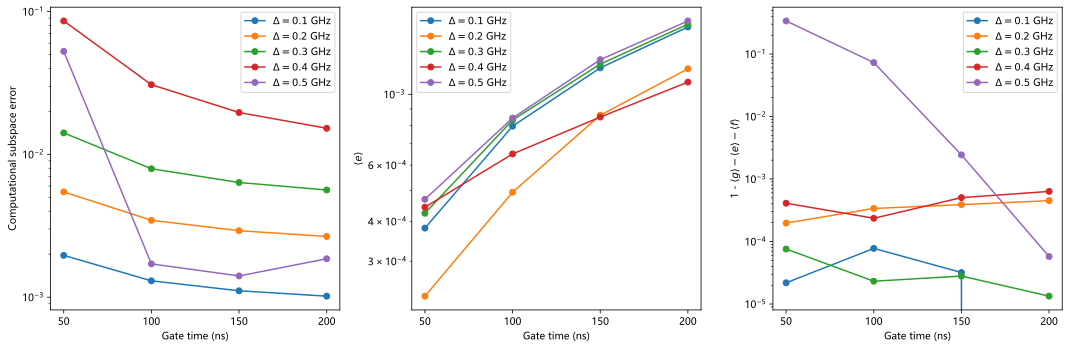

In [14]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figure size as needed

# Plot the first set of data (Computational subspace error)
for i, detuning in enumerate(detuning_arr):
    axs[0].plot(t_duration_arr, fidelity_arr[i], label=rf"$\Delta={detuning}$ GHz", marker='o')
axs[0].set_yscale('log')
axs[0].set_xticks([50, 100, 150, 200])
axs[0].set_xlabel("Gate time (ns)")
axs[0].set_ylabel("Computational subspace error")
axs[0].legend()

# Plot the second set of data (Leakage to e state)
for i, detuning in enumerate(detuning_arr):
    axs[1].plot(t_duration_arr, leak_to_e_arr[i], label=rf"$\Delta={detuning}$ GHz", marker='o')
axs[1].set_yscale('log')
axs[1].set_xticks([50, 100, 150, 200])
axs[1].set_xlabel("Gate time (ns)")
axs[1].set_ylabel(r"$\langle e \rangle$")
axs[1].legend()

# Plot the third set of data (Additional leakage)
for i, detuning in enumerate(detuning_arr):
    axs[2].plot(t_duration_arr, additional_leakage_arr[i], label=rf"$\Delta={detuning}$ GHz", marker='o')
axs[2].set_yscale('log')
axs[2].set_xticks([50, 100, 150, 200])
axs[2].set_xlabel("Gate time (ns)")
axs[2].set_ylabel(r"1 - $\langle g \rangle - \langle e \rangle - \langle f \rangle$")
axs[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
